# **TASI-2223-114 FAKE NEWS DETECTION**

*   12S19014 Kartika Lidya Rotua Sianipar
*   12S19039 Anugerah Salomo Rafael Simanjuntak
*   12S19059 Rut Yana Gultom

# **Load dataset**

In [1]:
import string
import re
import numpy as np
import xml.dom.minidom as minidom
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
df = pd.read_csv("turnbackhoax.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Label     1116 non-null   float64
 1   Headline  1116 non-null   object 
 2   Body      1114 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.3+ KB


In [3]:
df.sample(5)

,Label,Headline,Body
420,1.0,Video Petugas KPPS Coblos Surat Suara di Boyolali,"Peristiwa ini terjadi di TPS 8 Dukuh Winong, D..."
915,0.0,MINUMAN RED BULL MENGANDUNG SPERMA BANTENG,SUMBER : MEDIA SOSIAL NARASI :Red Bull and oth...
1069,0.0,Gatot Nurmantyo Akan Menghabisi Oknum PKI Wala...,Dua situs palsu (mencatut nama seakan-akan ada...
916,0.0,MOTOR TERBAKAR KARENA HP DIDALAM JOK,SUMBER : MEDIA SOSIAL NARASI : *Warning PooooL...
718,0.0,“Pengrusakan Mushola di Daerah Bojong Gede Ol...,“(1) Salinan laporan ke grup Whatsapp internal...


In [4]:
df_count = df.groupby('Label').agg(label=('Label','count'))
df_count

,label
Label,
0.0,683
1.0,433


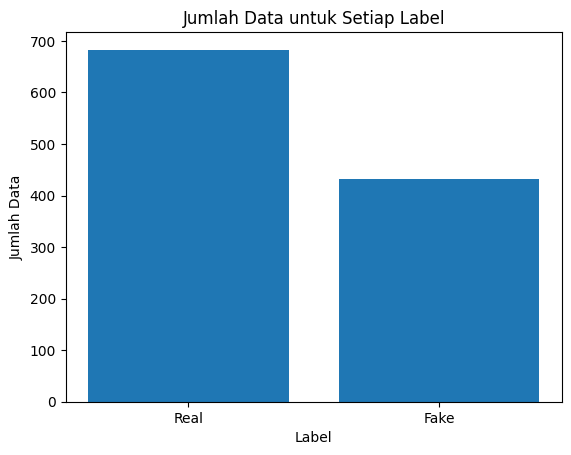

In [5]:
# hitung jumlah data untuk masing-masing label
count_label_0 = df[df['Label'] == 0].shape[0]
count_label_1 = df[df['Label'] == 1].shape[0]

# buat bar chart
labels = ['Real', 'Fake']
values = [count_label_0, count_label_1]
plt.bar(labels, values)

# atur judul dan label sumbu
plt.title('Jumlah Data untuk Setiap Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')

# tampilkan plot
plt.show()

## **Preprocessing dataset**

## Missing Value

In [6]:
print("Check Missing Value:\n" ,df.isnull().any())
df.isnull().sum()

Check Missing Value:
 Label       True
Headline    True
Body        True
dtype: bool


Label       2
Headline    2
Body        4
dtype: int64

In [7]:
data_notna = df[df['Label'].notna()]
data_notna = df[df['Headline'].notna()]
data_notna = df[df['Body'].notna()]

data_notna.isnull().sum()

Label       0
Headline    0
Body        0
dtype: int64

In [8]:
data_notna.to_csv("notna_turnbackhoax.csv")

## Remove Punctuation

In [48]:
# Fungsi untuk menghapus tanda baca
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

# Menghapus tanda baca pada kolom Headline
data_notna['Headline'] = data_notna['Headline'].apply(lambda x: remove_punctuation(x))

# Menghapus tanda baca pada kolom Body
data_notna['Body'] = data_notna['Body'].apply(lambda x: remove_punctuation(x))

# Cetak dataframe setelah tanda baca dihapus
data_nopunc = data_notna
print(data_nopunc)


C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\2492459202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_notna['Headline'] = data_notna['Headline'].apply(lambda x: remove_punctuation(x))


      Label                                           Headline  \
0       1.0  Pertamina dan Pemerintah Kalrifikasi Isu BBM N...   
1       1.0  Polda Nusa Tenggara Barat Mengklarifkasi Bahwa...   
2       1.0  PT Ultrajaya Milk Industry Tbk Mengklarifikasi...   
3       1.0  BBKSDA Jatim Mengklarifikasi Bahwa Wisata Alam...   
4       1.0  BMKG Mataram Menghimbau Agar Warga Tidak Langs...   
...     ...                                                ...   
1113    0.0   Vaksin Kanker Serviks Menyebabkan Menopause Dini   
1114    0.0  Video Cindera Mata Raja Salman Untuk Ibu Irian...   
1115    0.0  Video Simulasi Hacking Manipulasi Suara Pilgub...   
1116    0.0  Website KPU Gampang Jebol Karena Scriptnya Tel...   
1117    0.0               Yang Benci FPI Ada Lima Foto Gus Mus   

                                                   Body  
0     Foto Kumparancom Debunk ini berisi iKlarifikas...  
1     Foto Ilustrasi Perkosaan Debunk ini berisi kla...  
2     Debunk ini berisi klarifika

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\2492459202.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_notna['Body'] = data_notna['Body'].apply(lambda x: remove_punctuation(x))


## Case Folding

In [49]:
data_nopunc['Headline'] = data_nopunc['Headline'].str.lower()
data_nopunc['Body'] = data_nopunc['Body'].str.lower()

data_lower = data_nopunc
print(data_lower)

      Label                                           Headline  \
0       1.0  pertamina dan pemerintah kalrifikasi isu bbm n...   
1       1.0  polda nusa tenggara barat mengklarifkasi bahwa...   
2       1.0  pt ultrajaya milk industry tbk mengklarifikasi...   
3       1.0  bbksda jatim mengklarifikasi bahwa wisata alam...   
4       1.0  bmkg mataram menghimbau agar warga tidak langs...   
...     ...                                                ...   
1113    0.0   vaksin kanker serviks menyebabkan menopause dini   
1114    0.0  video cindera mata raja salman untuk ibu irian...   
1115    0.0  video simulasi hacking manipulasi suara pilgub...   
1116    0.0  website kpu gampang jebol karena scriptnya tel...   
1117    0.0               yang benci fpi ada lima foto gus mus   

                                                   Body  
0     foto kumparancom debunk ini berisi iklarifikas...  
1     foto ilustrasi perkosaan debunk ini berisi kla...  
2     debunk ini berisi klarifika

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\3538963477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nopunc['Headline'] = data_nopunc['Headline'].str.lower()
C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\3538963477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nopunc['Body'] = data_nopunc['Body'].str.lower()


## Stopword Removal

In [50]:
pip install Sastrawi

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [52]:
stopwords.remove('tidak')
stopwords.remove('tanpa')

In [53]:
stopwords.sort()

# print vowels
for i in stopwords:
  print(i)

ada
adalah
agak
agar
akan
amat
anda
antara
anu
apakah
apalagi
atau
bagaimanapun
bagi
bahwa
begitu
belum
bisa
boleh
dahulu
dalam
dan
dapat
dari
daripada
demi
demikian
dengan
di
dia
dimana
dll
dsb
dst
dua
dulunya
guna
hal
hanya
harus
ia
ingin
ini
itu
itulah
jika
jika
juga
juga
kah
kami
karena
ke
kecuali
kemana
kembali
kenapa
kepada
ketika
kita
lagi
lain
maka
mari
masih
melainkan
mengapa
menurut
mereka
namun
nanti
nggak
oh
ok
oleh
pada
para
pasti
pula
pun
saat
saja
sambil
sampai
saya
sebab
sebagai
sebelum
sebetulnya
secara
sedangkan
seharusnya
sehingga
sekitar
selagi
selain
sementara
sementara
seolah
seperti
seraya
serta
sesuatu
sesudah
setelah
seterusnya
setiap
setidaknya
sudah
supaya
tapi
telah
tentang
tentu
terhadap
tetapi
toh
tolong
untuk
walau
ya
yaitu
yakni
yang


In [54]:
def remove(text):
    factory = StopWordRemoverFactory()
    stopwords = factory.create_stop_word_remover()
    text = stopwords.remove(text)
    return text
data_lower['Headline'] = data_lower['Headline'].apply(lambda x: remove(x))
data_lower['Body'] = data_lower['Body'].apply(lambda x: remove(x))

data_clean = data_lower
print(data_clean)

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\4199550798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lower['Headline'] = data_lower['Headline'].apply(lambda x: remove(x))


      Label                                           Headline  \
0       1.0  pertamina pemerintah kalrifikasi isu bbm naik ...   
1       1.0  polda nusa tenggara barat mengklarifkasi tidak...   
2       1.0  pt ultrajaya milk industry tbk mengklarifikasi...   
3       1.0  bbksda jatim mengklarifikasi wisata alam kawah...   
4       1.0  bmkg mataram menghimbau warga langsung percaya...   
...     ...                                                ...   
1113    0.0   vaksin kanker serviks menyebabkan menopause dini   
1114    0.0  video cindera mata raja salman ibu iriana joko...   
1115    0.0  video simulasi hacking manipulasi suara pilgub...   
1116    0.0      website kpu gampang jebol scriptnya telanjang   
1117    0.0                        benci fpi lima foto gus mus   

                                                   Body  
0     foto kumparancom debunk berisi iklarifikasi pe...  
1     foto ilustrasi perkosaan debunk berisi klarifi...  
2     debunk berisi klarifikasi p

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\4199550798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lower['Body'] = data_lower['Body'].apply(lambda x: remove(x))


## Tokenization

In [55]:
df = data_clean

In [56]:
def tokenization(text1, text2):
    tokens1 = nltk.tokenize.word_tokenize(text1)
    tokens2 = nltk.tokenize.word_tokenize(text2)
    return tokens1, tokens2

def tokenize_columns(df, col1, col2):
    df_valid = df.loc[df[[col1, col2]].apply(lambda x: isinstance(x[col1], (str, bytes)) and isinstance(x[col2], (str, bytes)), axis=1), :]
    df_valid[['Tokenizing_Head', 'Tokenizing_Body']] = df_valid.apply(lambda x: pd.Series(tokenization(x[col1], x[col2])), axis=1)
    df.loc[df_valid.index, ['Tokenizing_Head', 'Tokenizing_Body']] = df_valid[['Tokenizing_Head', 'Tokenizing_Body']]
    return df

data_token = tokenize_columns(df, 'Headline', 'Body')
data_token

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\3588331584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df_valid.index, ['Tokenizing_Head', 'Tokenizing_Body']] = df_valid[['Tokenizing_Head', 'Tokenizing_Body']]


,Label,Headline,Body,Tokenizing_Head,Tokenizing_Body
0,1.0,pertamina pemerintah kalrifikasi isu bbm naik ...,foto kumparancom debunk berisi iklarifikasi pe...,"[pertamina, pemerintah, kalrifikasi, isu, bbm,...","[foto, kumparancom, debunk, berisi, iklarifika..."
1,1.0,polda nusa tenggara barat mengklarifkasi tidak...,foto ilustrasi perkosaan debunk berisi klarifi...,"[polda, nusa, tenggara, barat, mengklarifkasi,...","[foto, ilustrasi, perkosaan, debunk, berisi, k..."
2,1.0,pt ultrajaya milk industry tbk mengklarifikasi...,debunk berisi klarifikasi pt ultrajaya milk in...,"[pt, ultrajaya, milk, industry, tbk, mengklari...","[debunk, berisi, klarifikasi, pt, ultrajaya, m..."
3,1.0,bbksda jatim mengklarifikasi wisata alam kawah...,foto tribunnewscom debunk berisi klrifikasi se...,"[bbksda, jatim, mengklarifikasi, wisata, alam,...","[foto, tribunnewscom, debunk, berisi, klrifika..."
4,1.0,bmkg mataram menghimbau warga langsung percaya...,foto tribunnewscom jokowi sedang memantau loka...,"[bmkg, mataram, menghimbau, warga, langsung, p...","[foto, tribunnewscom, jokowi, sedang, memantau..."
...,...,...,...,...,...
1113,0.0,vaksin kanker serviks menyebabkan menopause dini,hoax vaksin kanker serviks anakanak sd menyeba...,"[vaksin, kanker, serviks, menyebabkan, menopau...","[hoax, vaksin, kanker, serviks, anakanak, sd, ..."
1114,0.0,video cindera mata raja salman ibu iriana joko...,sebuah akun twitter nama akun gerilyapolitik m...,"[video, cindera, mata, raja, salman, ibu, iria...","[sebuah, akun, twitter, nama, akun, gerilyapol..."
1115,0.0,video simulasi hacking manipulasi suara pilgub...,sebuah akun facebook memposting video dia sebu...,"[video, simulasi, hacking, manipulasi, suara, ...","[sebuah, akun, facebook, memposting, video, di..."
1116,0.0,website kpu gampang jebol scriptnya telanjang,sebuah akun facebook memposting status mengkla...,"[website, kpu, gampang, jebol, scriptnya, tela...","[sebuah, akun, facebook, memposting, status, m..."


## Save to New Dataset

In [57]:
# df.to_csv("clean_turnbackhoax.csv")

# **Split to Train, Test, Valid**

Proporsi masing-masing bagian yang digunakan yaitu 60% untuk data latih (train), 20% untuk data validasi (valid), dan 20% untuk data uji (test).

In [58]:
# one split data
train, sample, test = np.split(df.sample(frac=1), [int(.6*len(df)),
int(.8*len((df)))])

In [59]:
# Assign the train split
X_train = train[[train.columns[i] for i in range(train.shape[1]-1) ]]
y_train = train[train.columns[-1]]
# Assign the test split
X_test = test[[test.columns[i] for i in range(train.shape[1]-1) ]]
y_test = test[test.columns[-1]]
# Assign the validation split
X_sample = sample[[sample.columns[i] for i in 
                    range(sample.shape[1]-1) ]]
y_sample = sample[sample.columns[-1]]

# Print the sets data shapes
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_sample shape: {}".format(X_sample.shape))
print("y_sample shape: {}".format(y_sample.shape))

sample.head()

X_train shape: (668, 4)
X_test shape: (223, 4)
y_train shape: (668,)
y_test shape: (223,)
X_sample shape: (223, 4)
y_sample shape: (223,)


,Label,Headline,Body,Tokenizing_Head,Tokenizing_Body
159,1.0,cokelat “mermaid” memakan korban,update 30122020 1 artikel dibuat april 2019 me...,"[cokelat, “, mermaid, ”, memakan, korban]","[update, 30122020, 1, artikel, dibuat, april, ..."
719,0.0,“penjahat gunakan spray bius lumpuhkan korban”,“setelah ditelusuri lebih lanjut melansir jawa...,"[“, penjahat, gunakan, spray, bius, lumpuhkan,...","[“, setelah, ditelusuri, lebih, lanjut, melans..."
63,1.0,“klarifikasi gubernur anies terkait dirinya di...,gubernur dki jakarta anies baswedan membantah ...,"[“, klarifikasi, gubernur, anies, terkait, dir...","[gubernur, dki, jakarta, anies, baswedan, memb..."
350,1.0,penjelasan data fakta pernyataan djarot saiful...,faktanya masa presiden ke6 terdapat sejumlah p...,"[penjelasan, data, fakta, pernyataan, djarot, ...","[faktanya, masa, presiden, ke6, terdapat, seju..."
886,0.0,kh maimoen zubair doakan tidak baik ahok,sumber media sosial narasi “doa syakhina kh ma...,"[kh, maimoen, zubair, doakan, tidak, baik, ahok]","[sumber, media, sosial, narasi, “, doa, syakhi..."


In [60]:
df['Label'] = df['Label'].astype(int)

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\3577165278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].astype(int)


In [61]:
df.drop(["Headline"],axis=1, inplace=True)
df.drop(["Body"],axis=1, inplace=True)
df

C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\1592631389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Headline"],axis=1, inplace=True)
C:\Users\Kartika\AppData\Local\Temp\ipykernel_15064\1592631389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Body"],axis=1, inplace=True)


,Label,Tokenizing_Head,Tokenizing_Body
0,1,"[pertamina, pemerintah, kalrifikasi, isu, bbm,...","[foto, kumparancom, debunk, berisi, iklarifika..."
1,1,"[polda, nusa, tenggara, barat, mengklarifkasi,...","[foto, ilustrasi, perkosaan, debunk, berisi, k..."
2,1,"[pt, ultrajaya, milk, industry, tbk, mengklari...","[debunk, berisi, klarifikasi, pt, ultrajaya, m..."
3,1,"[bbksda, jatim, mengklarifikasi, wisata, alam,...","[foto, tribunnewscom, debunk, berisi, klrifika..."
4,1,"[bmkg, mataram, menghimbau, warga, langsung, p...","[foto, tribunnewscom, jokowi, sedang, memantau..."
...,...,...,...
1113,0,"[vaksin, kanker, serviks, menyebabkan, menopau...","[hoax, vaksin, kanker, serviks, anakanak, sd, ..."
1114,0,"[video, cindera, mata, raja, salman, ibu, iria...","[sebuah, akun, twitter, nama, akun, gerilyapol..."
1115,0,"[video, simulasi, hacking, manipulasi, suara, ...","[sebuah, akun, facebook, memposting, video, di..."
1116,0,"[website, kpu, gampang, jebol, scriptnya, tela...","[sebuah, akun, facebook, memposting, status, m..."


In [62]:
# import sklearn
from sklearn.model_selection import train_test_split
#split the data into train and test set
train,test = train_test_split(df, test_size=0.30, random_state=0)
#save the data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)
sample.to_csv('valid.csv',index=False)